In [1]:
import read_data as imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta import *
import itertools as it
# from tsne import *

import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [2]:
def normalize(x,time):
    return (x-x.rolling(time, min_periods = 1).min())/(x.rolling(time, min_periods = 1).max()-x.rolling(time, min_periods = 1).min())

def max_rate(x,time):
    return x/x.rolling(time, min_periods = 1).max()

def min_rate(x,time):
    return x/x.rolling(time, min_periods = 1).min()

def past_return(x,n):
    y = pd.DataFrame()
    for i in range(n):
        key = 'T-'+str(i+1)
        y[key] = x['Close']/x['Close'].shift(i+1)-1
    return y

In [3]:
dr = 0.01               # Desired return
Time_Window = 2         # Time window to see into the future
P_Ret = 10              # Past return to consider
max_min_tw = 10         # timewindow for support and resistance
n_means=[[20],[200]]    # moving averages for features
windows_ref = 60        # past information needed to normalize
precision = 0.99        # precision to pick the number of eigen vectors to use

dropable_col = ['volatility_kchi', 'volatility_kcli', 'trend_adx', 'trend_adx_pos',
                'volatility_atr', 'volatility_bbhi', 'volatility_dchi', 'trend_adx_neg',
                'volatility_bbli', 'volatility_dcli']


In [4]:
symbols = ['SPY','XLP','XLY','XLE','XLF','XLV','XLI','XLK','XLU']
features = list(pd.read_csv("Features.txt", sep="\n", header=None)[0].values)

In [5]:
years = [x for x in range(2000,2019)]
hist_data = imp.organizarTodo(symbols,years)
hist_feature = imp.organizarTodo(features,years,True)

In [6]:
features = {**hist_data, **hist_feature}
SPY = features.pop('SPY')
SPY

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,148.2500,148.2500,143.8750,145.4375,8164300
2000-01-04,143.5313,144.0625,139.6406,139.7500,8089800
2000-01-05,139.9375,141.5313,137.2500,140.0000,12177900
2000-01-06,139.6250,141.5000,137.7500,137.7500,6227200
2000-01-07,140.3125,145.7500,140.0625,145.7500,8066500
2000-01-10,146.2500,146.9063,145.0313,146.2500,5741700
2000-01-11,145.8125,146.0938,143.5000,144.5000,7503700
2000-01-12,144.5938,144.5938,142.8750,143.0625,6907700
2000-01-13,144.4688,145.7500,143.2813,145.0000,5158300


In [14]:
HF = pd.DataFrame(columns=hist_feature.keys())

for feat,df in hist_feature.items():
    df_aux = df.copy()
    HF[feat] = df_aux['Close']
    for i in it.product(*n_means):
        HF[feat+'_MAS_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].rolling(window=i[1], min_periods = 1).mean()-df_aux['Close'].rolling(window=i[0], min_periods = 1).mean()
        HF[feat+'_MAR_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].rolling(window=i[1], min_periods = 1).mean()/df_aux['Close'].rolling(window=i[0], min_periods = 1).mean()
        HF[feat+'_EMAS_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].ewm(span=i[1], adjust=False, min_periods = 1).mean()-df_aux['Close'].ewm(span=i[0], adjust=False, min_periods = 1).mean()
        HF[feat+'_EMAR_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].ewm(span=i[1], adjust=False, min_periods = 1).mean()/df_aux['Close'].ewm(span=i[0], adjust=False, min_periods = 1).mean()

HF['GT10-5'] = HF['GT10 Govt'] - HF['GT5 Govt']
HF['GT10-2'] = HF['GT10 Govt'] - HF['GT2 Govt']
HF['GT5-2'] = HF['GT5 Govt'] - HF['GT2 Govt']

In [15]:
buy = np.array(SPY['Close']/SPY['Close'].shift(-Time_Window)-1 > dr)
Class = np.zeros(SPY.shape[0])
Class[np.where(buy)] = 1
Class = pd.DataFrame(Class)
Class.columns = ['Class']

In [20]:
aux = SPY.copy()
SPY = add_all_ta_features(SPY, "Open", "High", "Low", "Close", "Volume", fillna=True)
SPY['Vol_Max'] = max_rate(SPY['Volume'],max_min_tw)
SPY['Clo_Max'] = max_rate(SPY['Close'],max_min_tw)
SPY['Ope_Max'] = max_rate(SPY['Open'],max_min_tw)
SPY['Hig_Max'] = max_rate(SPY['High'],max_min_tw)
SPY['Low_Max'] = max_rate(SPY['Low'],max_min_tw)

SPY['Vol_Min'] = max_rate(SPY['Volume'],max_min_tw)
SPY['Clo_Min'] = max_rate(SPY['Close'],max_min_tw)
SPY['Ope_Min'] = max_rate(SPY['Open'],max_min_tw)
SPY['Hig_Min'] = max_rate(SPY['High'],max_min_tw)
SPY['Low_Min'] = max_rate(SPY['Low'],max_min_tw)

SPY['Support'] = SPY['Close']/SPY['High'].rolling(window=max_min_tw, min_periods = 1).max()
SPY['Resistance'] = SPY['Close']/SPY['Low'].rolling(window=max_min_tw, min_periods = 1).min()

SPY['Open'] = SPY['Open']/SPY['Open'].shift(1)-1
SPY['High'] = SPY['High']/SPY['High'].shift(1)-1
SPY['Low'] = SPY['Low']/SPY['Low'].shift(1)-1
SPY['Close'] = SPY['Close']/SPY['Close'].shift(1)-1
SPY['Volume'] = SPY['Volume']/SPY['Volume'].shift(1)-1

SPY = SPY.drop(dropable_col, axis = 1)

df_past_r = past_return(aux, n = P_Ret)

Class.index = SPY.index
SPY = pd.concat([Class, SPY], axis = 1)
SPY = SPY.iloc[[not i for i in list(SPY['Close'].isna())],:]
SPY = SPY.dropna(axis = 0)


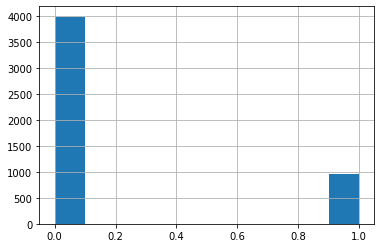

In [21]:
SPY['Class'].hist()

In [23]:
SPY.to_excel('Data.xlsx')